## AT dinucleotide repeats affect read depth

[Ross et al 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-r51) (Table 2) and [Smith et al 2015](https://peerj.com/articles/836/) (Fig 3) established that sequences containing AT dinucleotide repeats tend to have lower read depths than random sequences. Let's check to see if that is the case in the CEPH data set. 

First, generate a set of positive examples, containing AT dinucleotide repeats, and a set of negative examples, chosen randomly from chromosome 22. Then, compare the distributions of read depths, conditioned upon whether the sequence contains the AT-dinucleotide-repeat motif or not: 

In [1]:
from Bio import SeqIO
import re
from load_preprocess_data import read_depths, _add_sequences
from utility import named_tuple
import pandas as pd 
from collections import OrderedDict
import numpy as np 

def create_positive_examples(pattern, sequence_length, chromosome_number, chromosome, depths): 
    starts = []
    ends = []
    centers = []
    sequences = []
    observed_depths = []
    # use regex lookahead to find overlapping matches: 
    # Based upon steve's answer at https://www.biostars.org/p/209383/
    for match in re.finditer('(?={})'.format(pattern), chromosome):
        padding_left = (sequence_length - len(pattern))//2
        padding_right = sequence_length - len(pattern) - padding_left
        start = match.start() - padding_left
        end = match.start() + len(pattern) + padding_right
        starts.append(start)
        ends.append(end)
        center = start + sequence_length//2
        centers.append(center)
        sequences.append(chromosome[start:end])
        observed_depths.append(depths[center])

    return pd.DataFrame(OrderedDict([('chromosome_number', chromosome_number),
                                     ('start', starts),
                                     ('center', centers),
                                     ('end', ends),
                                     ('sequence', sequences),
                                     ('observed_depth', observed_depths)]))

def create_negative_examples(sequence_length, chromosome_number, chromosome, depths, size, 
                             a=20000000, b=50000000): 
    # negative examples are unlikely to coincide with positive examples, 
    # since the latter are so rare
    starts = np.random.choice(np.arange(a, b-sequence_length+1),
                              size=size,
                              replace=False)
    ends = starts + sequence_length
    centers = starts + sequence_length//2
    observed_depths = depths[centers]

    data = pd.DataFrame(OrderedDict([('chromosome_number', chromosome_number),
                                     ('start', starts),
                                     ('center', centers),
                                     ('end', ends),
                                     ('observed_depth', observed_depths)]))
        
    return _add_sequences(data, chromosome).sort_values('start')

def create_examples(pattern,
                    sequence_length,   
                    depth_file,
                    fasta_file='../data/sequences/human_g1k_v37.fasta'):
    for record in SeqIO.parse(fasta_file, 'fasta'):
        chromosome_number = record.id
        if chromosome_number != '22': 
            continue
        chromosome = str(record.seq)
        args = named_tuple({'chromosome_number': int(chromosome_number), 
                            'depth_file_name': depth_file})
        depths = read_depths(args)
        
        assert(len(pattern) < sequence_length)
        _positive_examples = create_positive_examples(pattern, sequence_length, chromosome_number, chromosome, depths)    
        _negative_examples = create_negative_examples(sequence_length, chromosome_number, chromosome, depths, size=len(_positive_examples))

        return _positive_examples, _negative_examples, pattern

import matplotlib.pyplot as plt
%matplotlib inline 

def _plot_read_depth_distribution(_positive_examples, _negative_examples, _dinucleotide): 
    mean_depth = np.mean(_negative_examples['observed_depth']) 

    plt.figure(figsize=(10,5))    
    bins = np.linspace(0, 3, 100)
    plt.hist(_positive_examples['observed_depth']/mean_depth, bins, alpha=0.5, label='positive examples')
    plt.hist(_negative_examples['observed_depth']/mean_depth, bins, alpha=0.5, label='negative examples')
    
    def compute_model_depths(examples):         
        return np.random.poisson(
            lam=np.mean(examples['observed_depth']),
            size=len(examples)
        )
    
    plt.hist(compute_model_depths(_positive_examples)/mean_depth, bins, alpha=0.5, label='positive examples (pure poisson model)')
    plt.hist(compute_model_depths(_negative_examples)/mean_depth, bins, alpha=0.5, label='negative examples (pure poisson model)')

    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('linear')
    _ = plt.title('mean depth: {:.1f}'.format(mean_depth) + '  dinucleotide: ({}){}'.format(_dinucleotide[:2], len(_dinucleotide)//2))
    
def plot_read_depth_distribution(pattern, depth_file='../data/depths/100.multicov.int32.bin'):
    _plot_read_depth_distribution(*create_examples(pattern=pattern, sequence_length=50, depth_file=depth_file))    
    
AT2 = 'ATAT'
AT5 = 'ATATATATAT'    
AT10 = 'ATATATATATATATATATAT'
AT15 = 'ATATATATATATATATATATATATATATAT'
AT20 = 'ATATATATATATATATATATATATATATATATATATATAT'

AA10 = 'AAAAAAAAAAAAAAAAAAAA'
TT10 = 'TTTTTTTTTTTTTTTTTTTT'



First, let's demonstrate that the signal-to-noise ratio is maximal when the mean depth is largest: 

In [2]:
# plot_read_depth_distribution(pattern=AT10, depth_file='../data/depths/1.multicov.int32.bin')
# plot_read_depth_distribution(pattern=AT10, depth_file='../data/depths/10.multicov.int32.bin')
# plot_read_depth_distribution(pattern=AT10, depth_file='../data/depths/100.multicov.int32.bin')

Next, let's find the optimal motif length: 

In [3]:
# plot_read_depth_distribution(AT2)
# plot_read_depth_distribution(AT5)
# plot_read_depth_distribution(AT10)
# plot_read_depth_distribution(AT15)
# plot_read_depth_distribution(AT20)


A motif consisting of 10 dinucleotide repeats seems to be a decent trade-off between (i) having a significant difference of read depth between positive and negative examples and (ii) having enough examples of the positive class. 

## Prepare training and testing data 

Let's use pooled samples to train and test a deep-learning model:

In [4]:
def build_data_frame(depth_file): 
    positive_examples, negative_examples, dinucleotide = create_examples(pattern=AT10, sequence_length=30, depth_file=depth_file)
    
    negative_examples['class'] = 0
    positive_examples['class'] = 1

    df = pd.concat([negative_examples, positive_examples], ignore_index=True, sort=False)
    
    import os
    number_samples, tool, dtype, suffix = os.path.basename(depth_file).split('.')
    df['number_samples'] = number_samples

    mean_depth = np.mean(negative_examples['observed_depth']) 
    df['mean_depth'] = mean_depth
    df['uncorrected_depth'] = df['observed_depth']/mean_depth

    # shuffle data
    return df.sample(frac=1) 

def build_data_frames(depth_file):
    df = build_data_frame(depth_file)

    # split data
    test_dev_sets_size = min(1000, int(0.1*len(df)))

    # make copies to avoid settingwithcopywarning: https://www.dataquest.io/blog/settingwithcopywarning
    df_test = df[:test_dev_sets_size].copy()
    df_dev = df[test_dev_sets_size:2*test_dev_sets_size].copy()
    df_train = df[2*test_dev_sets_size:].copy()
    
    return df_test, df_dev, df_train


In [5]:

# data_test, data_dev, data_train = build_data_frames(depth_file='../data/depths/100.multicov.int32.bin')

# data_test.to_pickle('./test.pkl')
# data_dev.to_pickle('./dev.pkl')
# data_train.to_pickle('./train.pkl')



Ultimately, we will need to correct depths on a single sample, so let's get data from a single sample too: 

In [6]:
# data_single_sample = build_data_frame(depth_file='../data/depths/1.multicov.int32.bin')
# data_single_sample.to_pickle('./single_sample.pkl')


In [7]:
import pandas as pd
data_test = pd.read_pickle('./test.pkl')
data_dev = pd.read_pickle('./dev.pkl')
data_train = pd.read_pickle('./train.pkl')
data_single_sample = pd.read_pickle('./single_sample.pkl')


## Code to train and evaluate models

In [8]:
from tensorflow.keras.backend import clear_session
import tensorflow as tf 
import tensorflow_probability as tfp 

from tensorflow import enable_eager_execution
enable_eager_execution()

import numpy as np 

def fetch_sequence_length(df):
    return len(df['sequence'].iloc[0])

def fetch_number_samples(df):
    return int(df['number_samples'].iloc[0])

def fetch_mean_depth(df):
    return df['mean_depth'].iloc[0]

from load_preprocess_data import _preprocess_conv1d
from tensorflow.keras.callbacks import Callback
tfd = tfp.distributions

def joint(distribution): 
    return tfd.Independent(distribution, reinterpreted_batch_ndims=2)
    
class CustomHistory(Callback):
    def __init__(self, data_train_, data_dev_, data_test_):
        self.data_train_ = data_train_
        self.data_dev_ = data_dev_
        self.data_test_ = data_test_
        
    # loss WITHOUT L1 or L2 regularization,
    # which is appropriate for assessing the extent to which the model suffers from bias and variance
    def loss(self, data_):
        X, y = _preprocess_conv1d(data_)
        # invoking "model(X)" guarantees that loss is computed without dropout 
        log_likelihood = joint(self.model(X)).log_prob(y)
        return -log_likelihood.numpy()/len(X)

    def on_train_begin(self, logs={}):
        self.epochs = []
        self.train_losses = []
        self.dev_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.train_losses.append(self.loss(self.data_train_))
        self.dev_losses.append(self.loss(self.data_dev_))
        self.test_losses.append(self.loss(self.data_test_))
        
def train(model_, data_train_, data_dev_, data_test_, number_epochs=100):   
    model_.number_samples = fetch_number_samples(data_train_) 
    
    custom_history = CustomHistory(data_train_, data_dev_, data_test_)

    X_train_, y_train_ = _preprocess_conv1d(data_train_)
    X_dev_, y_dev_ = _preprocess_conv1d(data_dev_)

    batch_size = 60
    standard_history = model_.fit(
        X_train_, 
        y_train_, 
        validation_data=(X_dev_, y_dev_),
        batch_size=batch_size,
        epochs=number_epochs,
        steps_per_epoch=len(X_train_)//batch_size, 
        callbacks=[custom_history]
    ) 
    
    return standard_history, custom_history



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [46]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_history(models, loss_max=100):
    plt.figure(figsize=figsize)    
    for name, standard_history, custom_history in models:
        plt.title(name)
        plt.plot(standard_history.epoch, 
                 standard_history.history['loss'], 
                 label='train loss that is optimized')
        plt.plot(custom_history.epochs, 
                 custom_history.train_losses, 
                 label='train loss', 
                 color='black')
        plt.plot(custom_history.epochs, 
                 custom_history.dev_losses, 
                 label='dev loss')
        plt.plot(custom_history.epochs, 
                 custom_history.test_losses, 
                 label='test loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(standard_history.epoch)])
        plt.ylim(0, loss_max)

normalized_lower_depth_threshold, normalized_upper_depth_threshold = 0.8, 1.2

def colors(df): 
    colors = []
    for class_membership in df['class']: 
        colors.append('red' if class_membership else 'green')
    return colors

def predict(model_, X_, number_samples_to_predict_on): 
    total_count = number_samples_to_predict_on * model_(X_).total_count / float(model_.number_samples)
    return tfd.NegativeBinomial(total_count=total_count, logits=model_(X_).logits)

def correct(df, model):
    number_examples_ = 1000
    if len(df) > number_examples_: 
        df = df.sample(number_examples_).copy()        
    X, _ = _preprocess_conv1d(df)
    # pd.options.mode.chained_assignment = None  # default='warn'    
    predicted_distribution = predict(model, X, fetch_number_samples(df))    
    df['predicted_mean'] = list(predicted_distribution.mean().numpy().squeeze())
    df['predicted_mean_normalized'] = df['predicted_mean']/df['mean_depth']
    df['corrected_depth'] = df['observed_depth']/df['predicted_mean']
    return df

def performance_metric(df):
    cond_lower = df['corrected_depth'].values > normalized_lower_depth_threshold
    cond_upper = df['corrected_depth'].values < normalized_upper_depth_threshold
    prob_corrected = np.sum(cond_lower & cond_upper)/float(len(df))
    cond_lower = df['uncorrected_depth'].values > normalized_lower_depth_threshold
    cond_upper = df['uncorrected_depth'].values < normalized_upper_depth_threshold
    prob_observed = np.sum(cond_lower & cond_upper)/float(len(df))
    return prob_corrected/prob_observed

figsize=(10,5)

def plot_gamma_single_sample(model_): 
    plt.figure(figsize=figsize)
    plt.title('inferred gamma distributions for a single sample')
    plot_pdf(compute_gamma_single_sample__class_specific(model_, class_=0), color='green', label='negative examples')
    plot_pdf(compute_gamma_single_sample__class_specific(model_, class_=1), color='red', label='positive examples')
    plt.ylabel('probability density function')
    plt.xlabel('read depth')

    # remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    plt.legend(newHandles, newLabels)

def plot_pdf(distributions, color, label): 
    depths = np.linspace(start=0, stop=60, num=100)
    #  https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html#general-broadcasting-rules :
    pdfs = distributions.prob(depths)
    plt.plot(depths, tf.transpose(pdfs), color=color, label=label)
    
def compute_gamma_single_sample__class_specific(model_, class_):
    df = data_test
    df = df[df['class']==class_]
    X_, _ = _preprocess_conv1d(df)
    return compute_gamma_single_sample(model_, X_)

def compute_gamma_single_sample(model_, X_): 
    total_count = model_(X_).total_count / float(model_.number_samples)    
    p = model_(X_).probs
    return tfd.Gamma(concentration=total_count, rate=(1-p)/p)
    
def name_to_variable(): 
    return {'train': data_train, 
            'dev': data_dev, 
            'test': data_test, 
            'single_sample': data_single_sample}

def evaluate_performance(data_name, model, chromosome_number=22):    
    df = name_to_variable()[data_name].copy()

    assert (str(chromosome_number) == '22')
    df = df[df['chromosome_number'].astype('int') == chromosome_number]
    
    df = correct(df, model)
    
    normalized_max_depth = 2

    df_well_corrected = df[
        (df['corrected_depth'] > normalized_lower_depth_threshold) 
        &
        (df['corrected_depth'] < normalized_upper_depth_threshold)         
    ]

    plt.figure(figsize=figsize)
    plt.scatter(df[df['class'] == 1]['center'], 
                df[df['class'] == 1]['corrected_depth'], 
                marker='.',
                label='corrected depth (from positive class)',
                c='red',
                alpha=0.5)
    plt.scatter(df[df['class'] == 0]['center'], 
                df[df['class'] == 0]['corrected_depth'], 
                marker='.',
                label='corrected depth (from negative class)',
                c='green',
                alpha=0.5)
    plt.scatter(df['center'], 
                df['uncorrected_depth'],
                marker='o', facecolors='none', edgecolors='black', linewidth=0.25,
                label='uncorrected depth')
    plt.plot([0, max(df['center'])], [normalized_lower_depth_threshold, normalized_lower_depth_threshold], '--k')
    plt.plot([0, max(df['center'])], [normalized_upper_depth_threshold, normalized_upper_depth_threshold], '--k')
    plt.xlabel('genomic coordinate on chromosome {}'.format(chromosome_number))
    _ = plt.legend(loc='lower left')
    plt.ylim([0, normalized_max_depth])
    plt.title('{}; {} set; performance_metric = {:.3f}'.format(
        model.name,
        data_name, 
        performance_metric(df)))

    plt.figure(figsize=figsize)    
    plt.scatter(df['predicted_mean_normalized'],
                df['uncorrected_depth'],
                label=None,
                c=colors(df),
                alpha=0.5)
    plt.scatter(df_well_corrected['predicted_mean_normalized'], 
                df_well_corrected['uncorrected_depth'], 
                label='well-corrected examples',
                marker='o', facecolors='none', edgecolors='k',
                alpha=0.5)
    plt.xlabel('predicted mean depth (normalized)')
    plt.ylabel('observed depth (normalized)')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_upper_depth_threshold)*normalized_max_depth], 
             '--k')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_lower_depth_threshold)*normalized_max_depth], 
             '--k')
    true_mean_positive_normalized = np.mean(df[df['class']==1]['uncorrected_depth'])
    plt.plot([true_mean_positive_normalized, true_mean_positive_normalized], 
             [0, normalized_max_depth], 
             'red', label='observed mean depth for positive class (normalized)')        
    true_mean_negative_normalized = np.mean(df[df['class']==0]['uncorrected_depth'])
    plt.plot([true_mean_negative_normalized, true_mean_negative_normalized], 
             [0, normalized_max_depth], 
             'green', label='observed mean depth for negative class (normalized)')        
    plt.xscale('linear')
    plt.yscale('linear')
    plt.legend(loc='upper left')
    plt.title('{}; {} set'.format(model.name, data_name))
#     plt.gca().set_aspect('equal', adjustable='box')

def plot_depth_distribution(data_name, model): 
    df = name_to_variable()[data_name].copy()
    
    plt.figure(figsize=figsize)    
    bins = np.linspace(0, 3, 100)

    X, _ = _preprocess_conv1d(df)
    
    predicted_distribution = predict(model, X, fetch_number_samples(df))    
    df['predicted_sample'] = list(predicted_distribution.sample().numpy().squeeze())
    
    df_negative = df[df['class']==0]
    df_positive = df[df['class']==1]

    plt.hist(df_positive['uncorrected_depth'], bins, alpha=0.5, label='observations from positive class (normalized)')
    plt.hist(df_negative['uncorrected_depth'], bins, alpha=0.5, label='observations from negative class (normalized)')

    mean_depth = fetch_mean_depth(df)
    plt.hist(df_positive['predicted_sample']/mean_depth, bins, alpha=0.5, label='samples from predicted distributions from positive class (normalized)')
    plt.hist(df_negative['predicted_sample']/mean_depth, bins, alpha=0.5, label='samples from predicted distributions from negative class (normalized)')

    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('linear')
    plt.title('{} set; {}'.format(data_name, model.name))
    

## Baseline model

In [48]:
def build_model_10(sequence_length, learning_rate=0.02):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session()

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    batch_norm_regularization_strength = 0.01
    dense_regularization_strength = 0.005 
    
    tfk = tf.keras

    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=20, 
        use_bias=False,
        padding='valid',
        activation=None)(inputs)
    # https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network
    conv1 = tfkl.BatchNormalization(
        beta_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength),
        gamma_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength)
    )(conv1)
    conv1 = tfkl.Activation('relu')(conv1)
    conv1 = tfkl.Dropout(rate=0.2)(conv1)

    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation=None)(conv1)
    conv2 = tfkl.BatchNormalization(
        beta_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength),
        gamma_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength)
    )(conv2)
    conv2 = tfkl.Activation('relu')(conv2)
    conv2 = tfkl.Dropout(rate=0.2)(conv2)

    flatten = tfkl.Flatten()(conv2)
    flatten = tfkl.Dropout(rate=0.4)(flatten)

    dense = tfkl.Dense(
        40,
        activation=None,
        use_bias=False,
        kernel_regularizer=tfk.regularizers.l2(dense_regularization_strength)
    )(flatten)
    dense = tfkl.BatchNormalization(
        beta_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength),
        gamma_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength)
    )(dense)
    dense = tfkl.Activation('relu')(dense)
    dense = tfkl.Dropout(rate=0.2)(dense)

    parameters = tfkl.Dense(2, activation=None)(dense)
    
    tfpl = tfp.layers

    def make_distribution_fn(t): 
        return tfd.NegativeBinomial(
            # total_count need not be an integer: 
            # e.g., https://www.mathworks.com/help/stats/negative-binomial-distribution.html
            total_count=tf.exp(t[..., 0:1]), 
            logits=t[..., 1:2])
    
    # use default value of convert_to_tensor_fn paramter in DistributionLambda, 
    # since that is what is used in, e.g., IndependentPoisson: 
    # https://github.com/tensorflow/probability/blob/1aef41d3ccee0a6fb234a4869be2c9e31c528fa1/tensorflow_probability/python/layers/distribution_layer.py#L1048
    negative_binomial = tfpl.DistributionLambda(make_distribution_fn=make_distribution_fn) 
    
    outputs = negative_binomial(parameters)
        
    # access function name: https://www.oreilly.com/library/view/python-cookbook/0596001673/ch14s08.html
    import sys
    function_name = sys._getframe().f_code.co_name    
    model_ = tfk.Model(inputs=inputs, outputs=outputs, name='model_'+function_name.split('_')[-1])

    model_.summary()
    
    X, y = _preprocess_conv1d(data_test)
        
    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    
    return model_

model_10 = build_model_10(fetch_sequence_length(data_test))

model_10_standard_history, model_10_custom_history = train(model_10, data_train, data_dev, data_test, number_epochs=50) 



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 50)            4000      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 11, 50)            200       
_________________________________________________________________
activation (Activation)      (None, 11, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 6, 50)             200       
__________

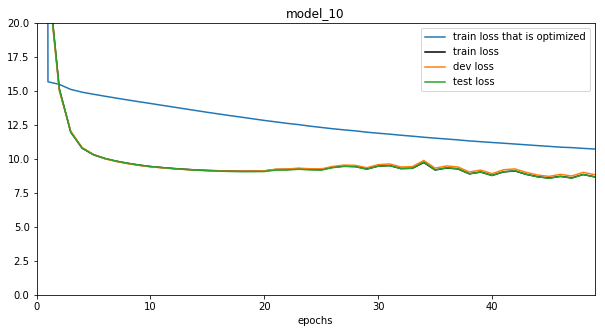

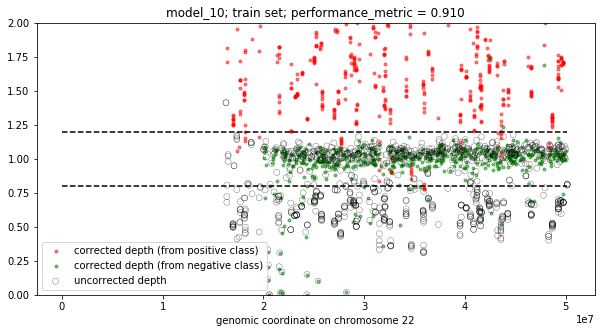

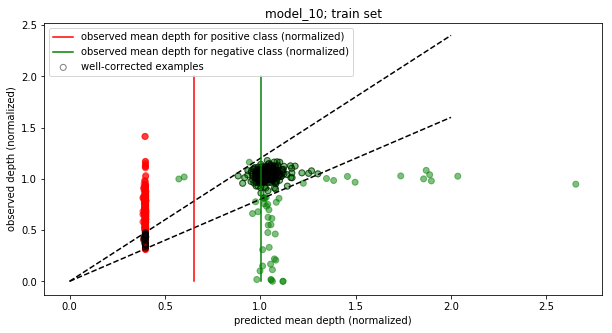

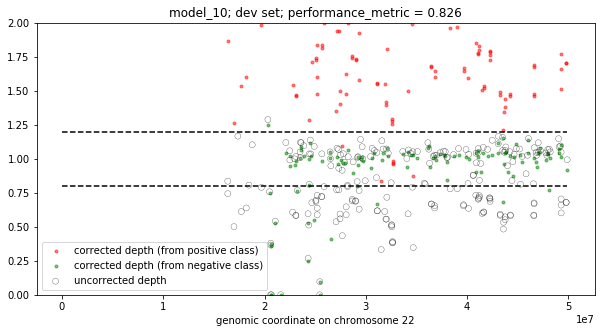

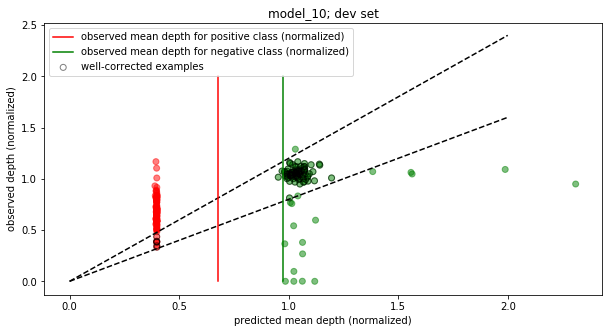

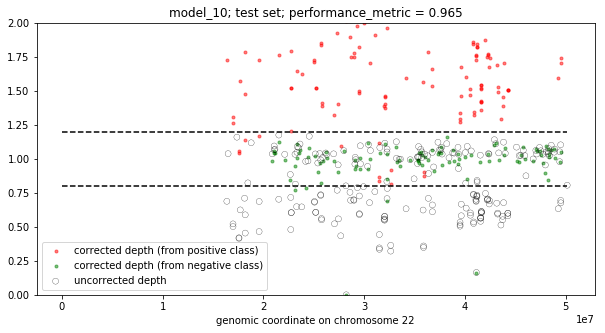

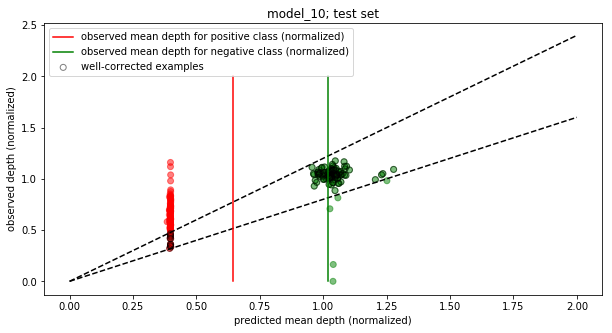

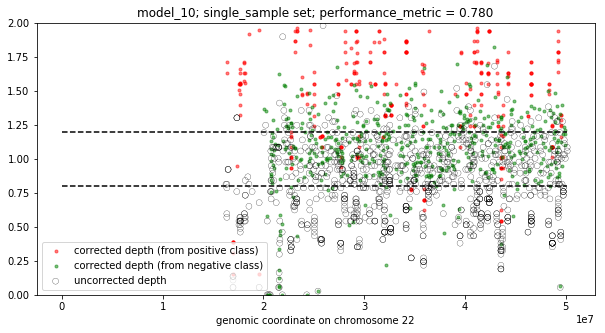

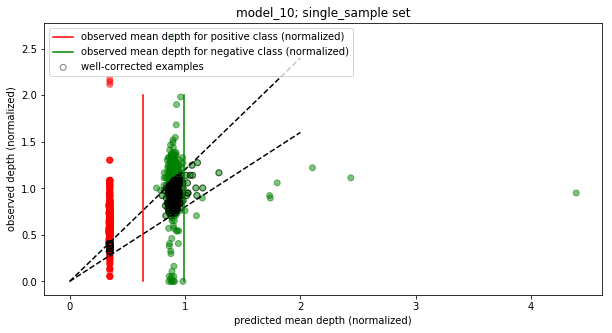

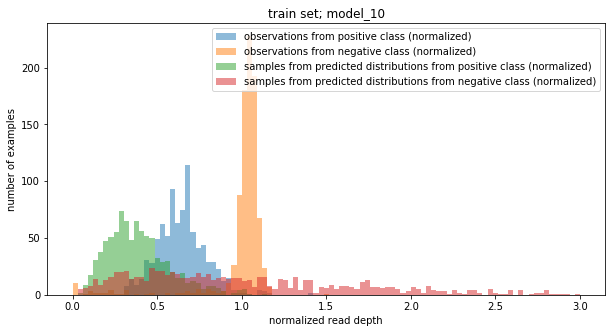

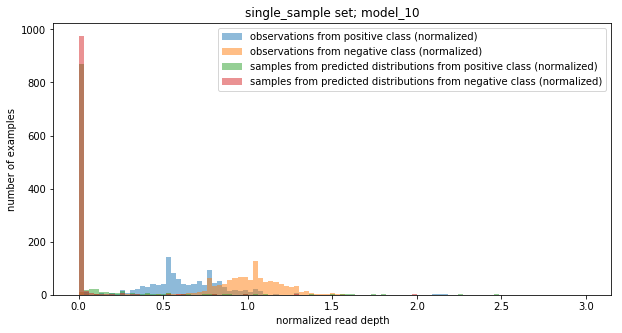

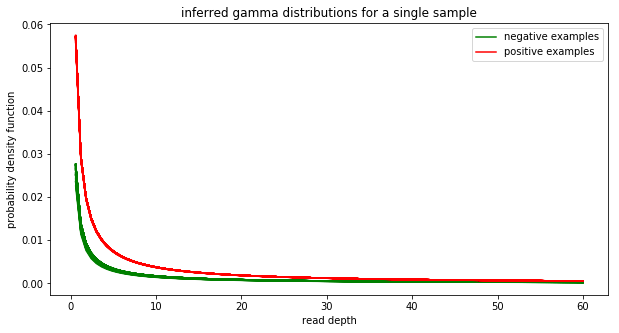

In [49]:
plot_history([('model_10', model_10_standard_history, model_10_custom_history)], loss_max=20)
evaluate_performance('train', model_10)
evaluate_performance('dev', model_10)
evaluate_performance('test', model_10)
evaluate_performance('single_sample', model_10)
plot_depth_distribution('train', model_10)
plot_depth_distribution('single_sample', model_10)
plot_gamma_single_sample(model_10)